In [1]:
import numpy as np
from astropy.modeling.blackbody import blackbody_lambda
from astropy import units as u
from astropy import constants as const
import simcado as sim
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
sim.__version__

'0.4dev-METIS'

### Number of photons generated in M1 space

In [3]:
area_ELT=np.pi*((37.3*u.m)**2-(11.1*u.m)**2)/4
eff_wave=11.5*u.micron ## N2 filter
bandwidth=(13.04-10.21)*u.micron ## N2 filter
solid_angle=(0.01078*u.arcsecond)**2
e_phot=const.h*const.c/eff_wave
r=blackbody_lambda(eff_wave,282*u.K)
emissivity_M1 = 0.03 # ESO ICD for ELT
n_ph_per_s=emissivity_M1*r*bandwidth*area_ELT*solid_angle/e_phot
print("Expected: The number of photons emitted from M1 per second per pixel is {0:.2E}".format(n_ph_per_s.decompose().value))

Expected: The number of photons emitted from M1 per second per pixel is 9.48E+07


Now compare this number to what Simcado computes

In [4]:
from simcado.spectral import BlackbodyCurve as sim_bb

In [5]:
## the wave array needs to have > 2 elements, otherwise edge effects 
## make the number of photons a factor of 2 too large
wave_array=np.arange(10.21,13.04,0.01)

In [6]:
em=sim_bb(wave_array,282-273,pix_res=0.01078,area=area_ELT.value)
em_n_ph=emissivity_M1*em.photons_in_range()
print("SimCADO: The number of photons emitted from M1 per second per pixel is \
{0:.2E}".format(em_n_ph))

SimCADO: The number of photons emitted from M1 per second per pixel is 9.45E+07


The two numbers are identical. Yay!

### Number of photons on the detector

In [137]:
cmd = sim.UserCommands("metis_image_NQ.config")
cmd["OBS_EXPTIME"]=0.01
cmd["ATMO_USE_ATMO_BG"] = "no"
cmd["SCOPE_USE_MIRROR_BG"] = "yes"
cmd["SIM_VERBOSE"]="no"

./../data/EC_mirrors_EELT_SCAO.tbl
././../data/EC_mirrors_EELT_SCAO.tbl
./././../data/EC_mirrors_EELT_SCAO.tbl
././././../data/EC_mirrors_EELT_SCAO.tbl
./././././../data/EC_mirrors_EELT_SCAO.tbl


In [138]:
cmd.mirrors_telescope

Mirror,Outer,Inner,Angle,Temp,Coating
str2,float64,float64,float64,float64,str38
M1,37.3,11.1,0.0,9.0,../data/TC_mirror_total_emissivity.dat


In [139]:
opt = sim.OpticalTrain(cmd)

././././././../data/EC_mirrors_EELT_SCAO.tbl
./././././././../data/EC_mirrors_EELT_SCAO.tbl
././././././././../data/EC_mirrors_EELT_SCAO.tbl
./././././././././../data/EC_mirrors_EELT_SCAO.tbl
././././././././././../data/EC_mirrors_EELT_SCAO.tbl
./././././././././././../data/EC_mirrors_EELT_SCAO.tbl
././././././././././././../data/EC_mirrors_EELT_SCAO.tbl
./././././././././././././../data/EC_mirrors_EELT_SCAO.tbl
././././././././././././././../data/EC_mirrors_EELT_SCAO.tbl
./././././././././././././././../data/EC_mirrors_EELT_SCAO.tbl
././././././././././././././././../data/EC_mirrors_EELT_SCAO.tbl
./././././././././././././././././../data/EC_mirrors_EELT_SCAO.tbl


In [140]:
fpa = sim.Detector(cmd, small_fov=False)

In [141]:
## generate a source with N=0.8 mag
lam, spec = sim.source.flat_spectrum(0.8, "../data/TC_filter_N2.dat")
#src = sim.Source(lam=lam, spectra=np.array([spec]), 
#                 ref=[0,0], x=[0,0.07], y=[0,0.07])
src = sim.Source(lam=lam, spectra=np.array([spec]), 
                 ref=[0], x=[0], y=[0])

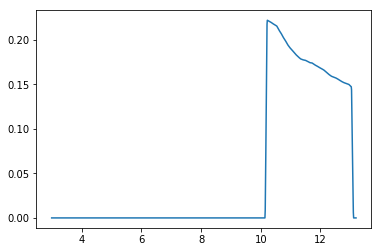

In [142]:
## Total transmission curve from M1 to the detector
## (i.e. the product of all TC files that are applicable)
plt.plot(opt.tc_mirror.lam,opt.tc_mirror)

#### Generate the transmission curves ourselves

In [143]:
TC_ELT=sim.spectral.TransmissionCurve("../data/TC_mirror_total_emissivity.dat")

In [144]:
TC_window=sim.spectral.TransmissionCurve("../data/TC_window_METIS.dat")

In [145]:
TC_dichroic_CFO=sim.spectral.TransmissionCurve("../data/TC_dichroic_CFO.dat")

In [146]:
# TC pupil is 1

In [147]:
TC_CFO_mirrors=sim.spectral.TransmissionCurve("../data/TC_mirror_aluminium.dat")

In [148]:
TC_CFO=TC_CFO_mirrors**19

In [149]:
TC_dichroic_IMG=sim.spectral.TransmissionCurve("../data/TC_dichroic_IMG.dat")

In [150]:
TC_N2=sim.spectral.TransmissionCurve("../data/TC_filter_N2.dat")

In [151]:
QE_AQUARIUS=sim.spectral.TransmissionCurve("../data/TC_detector_METIS_NQ.dat")

In [174]:
TC_total=TC_ELT*TC_window*TC_dichroic_CFO*TC_CFO*TC_dichroic_IMG*TC_N2*QE_AQUARIUS

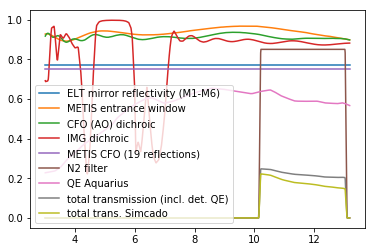

In [183]:
plt.plot(opt.tc_mirror.lam,TC_ELT,label="ELT mirror reflectivity (M1-M6)")
plt.plot(opt.tc_mirror.lam,TC_window,label="METIS entrance window")
plt.plot(opt.tc_mirror.lam,TC_dichroic_CFO,label="CFO (AO) dichroic")
plt.plot(opt.tc_mirror.lam,TC_dichroic_IMG,label="IMG dichroic")
plt.plot(opt.tc_mirror.lam,TC_CFO,label="METIS CFO (19 reflections)")
plt.plot(opt.tc_mirror.lam,TC_N2,label="N2 filter")
plt.plot(opt.tc_mirror.lam,QE_AQUARIUS,label="QE Aquarius")
plt.plot(opt.tc_mirror.lam,TC_total,label="total transmission (incl. det. QE)")
plt.plot(opt.tc_mirror.lam,opt.tc_mirror,label="total trans. Simcado")
plt.legend(loc=3)
plt.savefig("METIS_transmission_curves.png")

In [177]:
# reading off from the transmission curve plot
TC_total_N2 = 0.2
## for comparison: Roy's value
# transmission from M1 to just before the detector
transmission_Roy_nodet=0.356
transmission_Roy_withdet=transmission_Roy_nodet*0.6
transmission_Roy_withdet

0.21359999999999998

In [178]:
# number of background photons computed from simple calculation * transmission
n_ph_bg=em_n_ph*TC_total_N2
print("expected: The number of background photons per second per pixel shortly before the detector should be \
{0:.2E}".format(n_ph_bg))

expected: The number of background photons per second per pixel shortly before the detector should be 1.89E+07


#### Compute number of background photons in SimCADO simulated image

In [179]:
src.apply_optical_train(opt, fpa)
hdu = fpa.read_out(OBS_EXPTIME=1)

Generating image for chip 1
././././././././././../data/EC_mirrors_EELT_SCAO.tbl
Reading out chip 1 using superfast
1.3826081814e+13 131847891.992 307582675.12 131847891.992
1.38261e+14 1.3179e+08 3.07604e+08 1.31848e+08


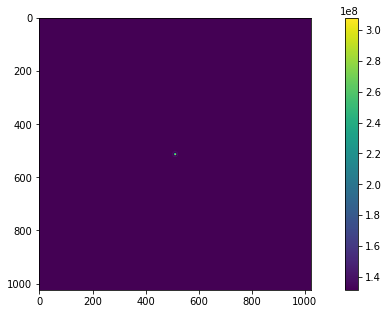

In [180]:
plt.figure(figsize=(12,5))
#plt.imshow(hdu[0].data[800:1200,500:1500], norm=LogNorm(), interpolation="none")
plt.imshow(hdu[0].data, interpolation="none")
plt.colorbar()

In [181]:
bgphotons_per_pix=np.median(hdu[0].data)
print("The number of bg photons per second per pix is {0:.2E}".format(bgphotons_per_pix))

The number of bg photons per second per pix is 1.32E+08
